In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile
from azureml.core import Workspace, Dataset
from azureml.core import Experiment
import os
import shutil
import azureml
from azureml.core import Workspace
from azureml.core import Experiment
from azureml.core.run import Run
import glob2 as glob
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
from zipfile import ZipFile

Read the raw data depth file, parse it and  return data and image dimesnion and depthscale

In [10]:
#read data
def read_data(raw_data):
    with open(raw_data, 'rb') as file:
        line = str(file.readline())[2:-3]
        header = line.split("_")
        res = header[0].split("x")
        width = int(res[0])
        height = int(res[1])
        depthScale = float(header[1])
        maxConfidence = float(header[2])
        data = file.read()
        file.close()
    return data, width, height, depthScale

### generating the depth map from raw bytes

In [329]:
def prepare_depthmap(data,image, width, height, depthScale):
        # prepare array for output
    pil_im = Image.open(image)
    pil_im = pil_im.resize((width,height), Image.ANTIALIAS)
    im_array = np.asarray(pil_im)
    output = np.zeros((width, height, 3))
    total_depth = []
    for i in range(0, width * height):
        depth = (data[i * 3 + 0] << 8) + data[i * 3 + 1] * depthScale
        total_depth.append(depth)
    #     confidence = data[i * 3 + 2] / maxConfidence
    #     if confidence == 0:
    #         percentage = 1.0
    #     else:
    #         percentage = (confidence - 1) / 7.0 # float 
    #     decoded_buffer.append((depth,confidence,percentage))
    #     x = int(i % width)
    #     y = int(i / width)
    #     output[x][y][0] = confidence
    #     output[x][y][1] = im_array[y][x][1] / 255.0 #test matching on RGB data
    #     output[x][y][2] = 1.0 - min(depth / 4.0, 1.0)
    #     output[x][y][2] = depth
    return (np.array(total_depth,dtype = 'float32').reshape(height, width), height, width)

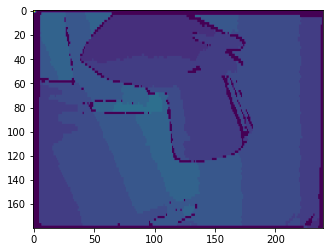

In [331]:
data, width, height, depthScale = read_data('data')
image,image_height,image_width = prepare_depthmap(data,'rgb.jpg',width, height, depthScale)
plt.imshow(image)

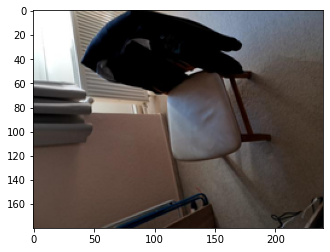

In [315]:
#show the image
pil_im = Image.open('rgb.jpg')
pil_im = pil_im.resize((image_width,image_height), Image.ANTIALIAS)
im_array = np.asarray(pil_im)
plt.imshow(im_array)

### Read and parse the camera calibration file

In [260]:
with open('camera_calibration.txt', 'r') as file:
    print(file.readline()[:-1])
    projection = []
    projection.append(convertArray(file.readline()))
    projection.append(convertArray(file.readline()))
    projection.append(convertArray(file.readline()))
    projection.append(convertArray(file.readline()))
    print(str(projection) + "\n")
    print(file.readline()[:-1])
    limits = []
    limits.append(convertArray(file.readline()))
    print(str(limits) + "\n")
    print(file.readline()[:-1])
    clip = []
    clip.append(convertMapping(file.readline()))
    clip.append(convertMapping(file.readline()))
    clip.append(convertMapping(file.readline()))
    clip.append(convertMapping(file.readline()))
    print(str(clip) + "\n")

Inverse of projection matrix:
[[0.35413176, -0.0, -0.0, -0.0], [-0.0, 0.6689155, -0.0, -0.0], [-0.0, -0.0, -0.0, -4.995], [0.00016774982, 5.00679e-05, -0.99999994, 5.005]]

Camera clip:
[[0.1, 100.0]]

Frame clip:
[[-1.0, -1.0, 0.99999994, 0.85294116], [1.0, -1.0, 0.99999994, 0.14705884], [-1.0, 1.0, 0.0, 0.85294116], [1.0, 1.0, 0.0, 0.14705884]]



### utility functions for depthmap to point cloud conversion

In [259]:
def convertArray(line):
    output = []
    values = line.split(" ")
    for value in values:
        output.append(float(value))
    return output;

def convertMapping(line):
    output = []
    values = line.split(" ")
    output.append(float(values[0]))
    output.append(float(values[1]))
    output.append(float(values[3]))
    output.append(float(values[4]))
    return output;
  
def transform(mat, vec):
    x = mat[0][0] * vec[0] + mat[1][0] * vec[1] + mat[2][0] * vec[2] + mat[3][0] * vec[3]
    y = mat[0][1] * vec[0] + mat[1][1] * vec[1] + mat[2][1] * vec[2] + mat[3][1] * vec[3]
    z = mat[0][2] * vec[0] + mat[1][2] * vec[1] + mat[2][2] * vec[2] + mat[3][2] * vec[3]
    w = mat[0][3] * vec[0] + mat[1][3] * vec[1] + mat[2][3] * vec[2] + mat[3][3] * vec[3]
    return [x / abs(z * w), y / abs(z * w), z / abs(w)]


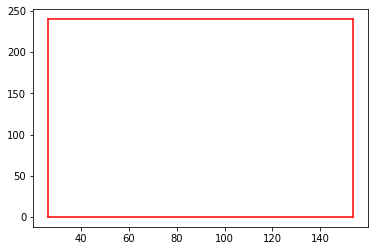

In [94]:
#visualize screenspace
fig = plt.figure()
minX = clip[2][2] * width
minY = clip[3][3] * height
maxX = clip[0][2] * width
maxY = clip[0][3] * height
plt.plot([maxY, minY], [minX, minX], 'r-')
plt.plot([minY, minY], [maxX, minX], 'r-')
plt.plot([minY, maxY], [maxX, maxX], 'r-')
plt.plot([maxY, maxY], [minX, maxX], 'r-')
dx = maxX - minX
dy = maxY - minY
aspect = dy / dx


### function to convert each depthmap point to pointlcloud 

In [332]:
def convert(mx, my):
    if mx >= 0 and my >= 0 and mx < width - 2 and my < height - 2:
    #get depth for the point
        depth = data[((height - my - 1) * width + mx) * 3 + 0] << 8
        depth += data[((height - my - 1) * width + mx) * 3 + 1]
        depth *= depthScale
    
        if depth > 0.05 and depth < 5:
            cx =-2.0 * (mx - minX) / dx + 1.0
            cy = 2.0 * (my - minY) / dy - 1.0
            len = limits[0][1] - limits[0][0]
            p0 = transform(projection, [cx, cy, 0, 1])
            p1 = transform(projection, [cx, cy, 1, 1])
            vec = []
            vec.append((p0[0] - p1[0]) / len * depth / aspect)
            vec.append((p0[1] - p1[1]) / len * depth * aspect)
            vec.append(depth)
            return vec
        else:
            return 0
    else:
        return 0

In [333]:
#write obj
with open('scan.obj', 'w') as file:
    for x in range(width):
        for y in range(height):
            res = convert(x, y)
            if res:
                file.write('v ' + str(res[0]) + ' ' + str(res[2]) + ' ' + str(-res[1]) + '\n')
    file.close()

In [336]:
from pyntcloud import PyntCloud
output = PyntCloud.from_file('scan.obj')
x= output.points['x']
y= output.points['y']
z= output.points['z']
# output.plot()
# output.to_file('new_output.pcd')

In [292]:
import ipyvolume as ipv
from scipy.spatial import distance

N = 1000
# x, y, z = np.random.normal(0, 1, (3, N))
fig = ipv.figure()
scatter = ipv.scatter(x, y, z)
ipv.selector_default()
ipv.show()
def height_info(*_):
    indices = scatter.selected[0]
    meanx = np.min(scatter.x[indices])
    meany = np.min(scatter.y[indices])
    print('mean x', meanx)
    print('mean y',meany)
scatter.observe(height_info, 'selected')
ipv.show()

Output()

In [270]:
# mean x -0.023695583
# mean y 1.392
# mean x 0.28427088
# mean y 1.043

X1 =[--0.023695583,1.392]
X2 =[0.28427088,1.043]
dst = distance.euclidean(X1, X2)
print(dst)

0.4355461920469954


## calling the models from dev environment for prediction on depth map

In [125]:
workspace = Workspace.from_config()
workspace

Workspace.create(name='cgm-ml-dev', subscription_id='9b82ecea-6780-4b85-8acf-d27d79028f07', resource_group='cgm-ml-dev')

In [126]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

checkboxes = []

for experiment_name, experiment in workspace.experiments.items():
    checkbox = widgets.Checkbox(
        value=False,
        description=experiment_name
    )
    display(checkbox)
    checkboxes.append(checkbox)

Checkbox(value=False, description='diabetes-experiment')

Checkbox(value=False, description='lop-test-cluster')

Checkbox(value=False, description='lop-test-experiment')

Checkbox(value=False, description='train-within-notebook')

Checkbox(value=False, description='sklearn-mnist')

Checkbox(value=False, description='tristan-diabetes-experiment')

Checkbox(value=False, description='dataset_unregistered_datasets')

Checkbox(value=False, description='tristan-local-experiment')

Checkbox(value=False, description='gapnet')

Checkbox(value=False, description='s1-gapnet-height')

Checkbox(value=False, description='s1-gapnet-weight')

Checkbox(value=False, description='lop-test-experiment-for-logging')

Checkbox(value=False, description='chris-sample-01-regression')

Checkbox(value=False, description='distributed-training-test')

Checkbox(value=False, description='s2-gapnet-weight')

Checkbox(value=False, description='s2-gapnet-height')

Checkbox(value=False, description='gapnet-offline')

Checkbox(value=False, description='Labeled-training')

Checkbox(value=False, description='IBM-Employeee-Tutorial-chris')

Checkbox(value=False, description='s4-cnndepthmap-height-offline')

Checkbox(value=False, description='s4-cnndepthmap-height')

Checkbox(value=False, description='s5-cnndepthmap-height')

Checkbox(value=False, description='s5-cnndepthmap-weight')

In [138]:
# Get the selected experiments.
selected_experiments = []
for checkbox in checkboxes:
    if checkbox.value == True:
        selected_experiments.append(checkbox.description)

# Get folder.
temp_path = "logs"
if os.path.exists(temp_path):
    shutil.rmtree(temp_path)
os.mkdir(temp_path)

# For each selected experiment download logs of all completed runs.
for selected_experiment in selected_experiments:
    print("Experiment: {}".format(selected_experiment))
    experiment = workspace.experiments.get(selected_experiment)
    for run_index, run in enumerate(list(experiment.get_runs())[::-1]):
        log_path = os.path.join(temp_path, experiment.name, "run_{:02d}".format(run_index + 1))
        if run.status == "Completed" and run.id == 's4-cnndepthmap-height_1583763039529':
            print("Run: {}".format(run_index + 1))
            run.download_files(output_directory=log_path, output_paths=None, batch_size=100, append_prefix=False)
#             run.download_files(prefix=".h5", output_directory=log_path, output_paths=None, batch_size=100, append_prefix=False)

print("Done.")

Experiment: s4-cnndepthmap-height
  Run: 26
Done.


In [339]:
## Load the model 

In [144]:
model = load_model('logs/s4-cnndepthmap-height/run_26/best_model.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 172, 8)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 172, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 86, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 86, 16)       1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 86, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 43, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 43, 32)        4

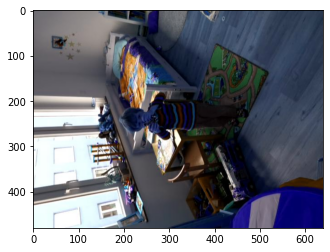

In [342]:
imgaes = 'test-mm-1/measurements/1588068923350/rgb/rgb_test-mm-1_1588068923350_100_790.jpg'
img =cv2.imread(imgaes)
plt.imshow(img)

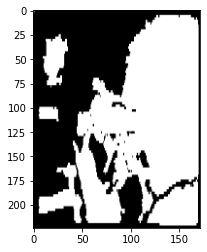

In [169]:
# import cv2
# test_image = cv2.imread("your_file.png")
# test_image =cv2.resize(test_image,(172,224))
# plt.imshow(test_image)

In [248]:
x = np.expand_dims(image, axis=2)
y= np.expand_dims(x, axis=0)
y.shape
score = model.predict(y)
# score
# x.shape

In [298]:
print("Actual height: 110")
print("predicted height:",score[0][0])

Actual height: 110
predicted height: 70.08741
